## Face Mask Detection Model

Face mask detection system using machine learning, specifically a Convolutional Neural Network (CNN) model. This system will analyze live video streams or recorded video to identify whether individuals are wearing face masks or not. By leveraging the power of deep learning, it aims to enhance safety and compliance with mask-wearing protocols in various environments, such as public spaces and healthcare settings.

### Requirements

- Numpy
- Matplotlib
- Scikit-Learn
- TensorFlow
- Keras
- ImUtils
- OpenCV-Python
- Scipy

*Additional* - Download and Install CUDA and cuDNN for better performance in tensorflow training

### Import Required Libraries

In [1]:
import os
import numpy as np
import itertools
from enum import Enum
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### CNN Architecture Class

In [4]:
# different types of CNN architecture
class CNN_TYPE(Enum):
    VGGNET = 1
    GOOGLENET = 2
    RESNET = 3
    MOBILENET = 4  

In [5]:
# set the type to RESNET
current_cnn_type = CNN_TYPE.RESNET

### A Function for Retrieving CNN Models and Preprocessing Functions

In [6]:
# to initialize and configure a CNN model and its associated preprocessing function 
def get_cnn_mode(type, image_shape):
    preprocess_input = []
    abc_model = []
    t2wi_model = []
    if type==CNN_TYPE.VGGNET:
        preprocess_input = tf.keras.applications.vgg16.preprocess_input
        model = tf.keras.applications.VGG16(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
    elif type==CNN_TYPE.GOOGLENET:    
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input
        model = tf.keras.applications.InceptionV3(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
    elif type==CNN_TYPE.RESNET:    
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
        model = tf.keras.applications.ResNet50(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
    elif type==CNN_TYPE.MOBILENET:    
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

    else:
        preprocess_input = tf.keras.applications.vgg19.preprocess_input
        model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
    return preprocess_input, model

In [7]:
# the shape of an image with a width of 224 pixels, a height of 224 pixels, and 3 color channels (typically red, green, and blue)
img_shape = (224, 224, 3)
preprocess_input, base_model = get_cnn_mode(current_cnn_type, img_shape)

### Loading and Preprocessing Images for Face Mask Detection

In [8]:
# initialize the initial learning rate, number of epochs to train for and batch size
lr = 1e-4
epochs = 10
batch_size = 32
input_path = "FaceMask_Dataset"
clasess = ["WithMask", "WithoutMask"]

In [9]:
# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
print("[INFO] loading images...")

images = []
labels = []
for each_cls in clasess:
    path = os.path.join(input_path, each_cls)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        images.append(image)
        labels.append(each_cls)

[INFO] loading images...


### One-Hot Encoding and Data Augmentation

In [10]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

images = np.array(images, dtype="float32")
labels = np.array(labels)

(x_train, x_test, y_train, y_test) = train_test_split(images, labels,test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
data_augumentation = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
# shape of x_train
x_train.shape

(1600, 224, 224, 3)

### Creating and Compile the Model

In [12]:
# construct the head of the model that will be placed on top of the base model
model = base_model.output
#model = AveragePooling2D(pool_size=(7, 7))(model)

model=tf.keras.layers.GlobalAveragePooling2D()(model)
model = Flatten(name="flatten")(model)
model = Dense(128, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)

model = Model(inputs=base_model.input, outputs=model)

for layer in base_model.layers:
	layer.trainable = False

In [13]:
# compile our model
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [14]:
# summary of the architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Training the Model

In [15]:
# train the model
history = model.fit(data_augumentation.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,validation_data=(x_test, y_test),
	                validation_steps=len(x_test) // batch_size,
	                epochs=epochs)

Epoch 1/100
50/50 [==============================] - 127s 2s/step - loss: 0.3909 - accuracy: 0.8706 - val_loss: 0.0905 - val_accuracy: 0.9950
Epoch 2/100
50/50 [==============================] - 126s 3s/step - loss: 0.1276 - accuracy: 0.9669 - val_loss: 0.0431 - val_accuracy: 0.9975
Epoch 3/100
50/50 [==============================] - 117s 2s/step - loss: 0.0788 - accuracy: 0.9825 - val_loss: 0.0261 - val_accuracy: 0.9950
Epoch 4/100
50/50 [==============================] - 121s 2s/step - loss: 0.0683 - accuracy: 0.9825 - val_loss: 0.0218 - val_accuracy: 0.9975
Epoch 5/100
50/50 [==============================] - 119s 2s/step - loss: 0.0551 - accuracy: 0.9837 - val_loss: 0.0170 - val_accuracy: 0.9975
Epoch 6/100
50/50 [==============================] - 119s 2s/step - loss: 0.0491 - accuracy: 0.9869 - val_loss: 0.0154 - val_accuracy: 0.9975
Epoch 7/100
50/50 [==============================] - 118s 2s/step - loss: 0.0387 - accuracy: 0.9912 - val_loss: 0.0143 - val_accuracy: 0.9975
Epoch 

### Visualizations

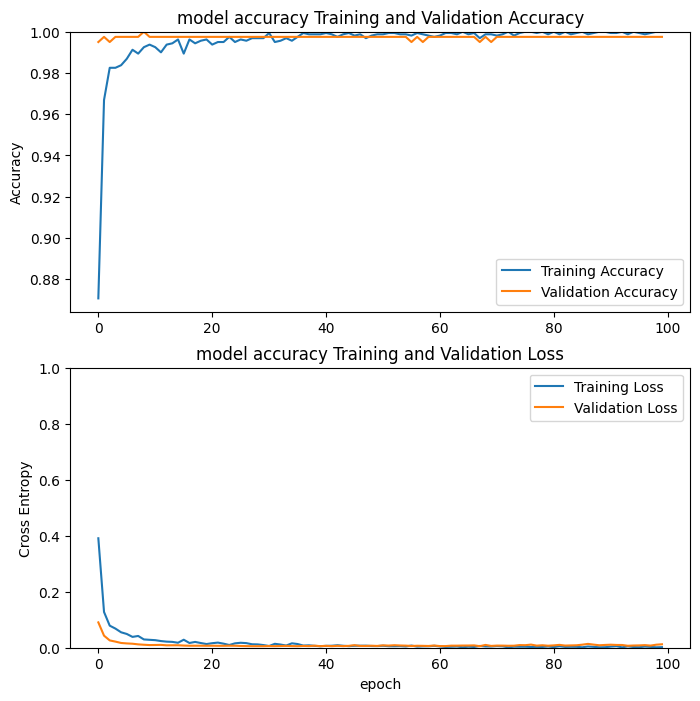

In [16]:
# visualizes the training and validation accuracy as well as the training and validation loss over epochs
def train_histor_view(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label= 'Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(name + ' ' + 'Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(name + ' ' + 'Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

train_histor_view(history, 'model accuracy')

In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=batch_size)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# shows a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=lb.classes_))

[INFO] evaluating network...
13/13 [==============================] - 19s 1s/step
              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       200
 WithoutMask       1.00      0.99      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



Confusion matrix, without normalization
[[200   0]
 [  1 199]]


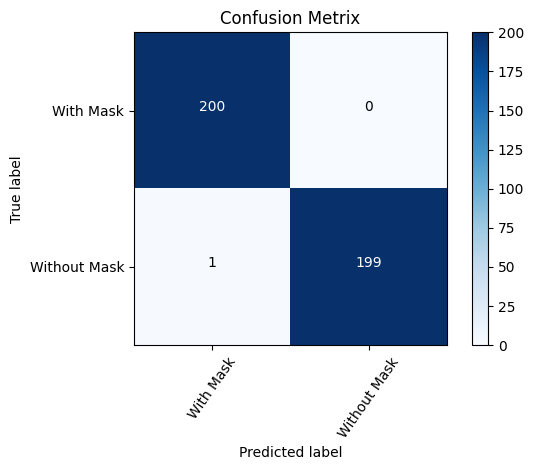

In [19]:
# to generate and display a confusion matrix for a classification task
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)

cm_plot_label =['With Mask', 'Without Mask']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix')

In [20]:
def calculate_sensitivity_specificity(y_test, y_pred_test):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_test == y_test)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy

In [21]:
# calculates and reports the sensitivity, specificity, and overall accuracy of a classification model's performance
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(y_test.argmax(axis=1), predIdxs)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 0.995
Specificity: 1.0
Accuracy: 0.9975


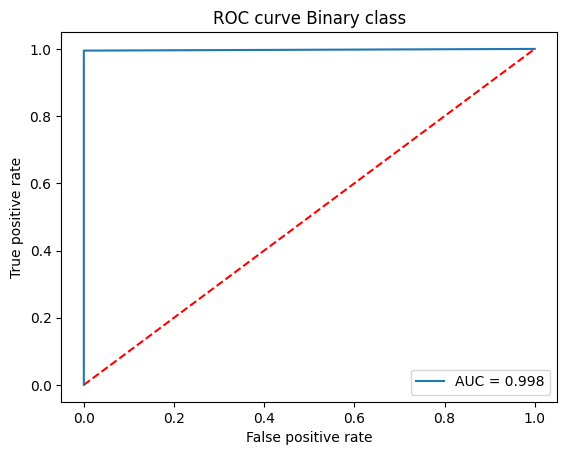

In [22]:
# visualizes the performance of a binary classification model using a Receiver Operating Characteristic (ROC) curve
roc_log = roc_auc_score(y_test.argmax(axis=1), predIdxs)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test.argmax(axis=1), predIdxs)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Binary class')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

### Saving and Loading The Model

In [23]:
# save the model (will save in .h5 format)
model.save('RESNET.h5')
print('Model Saved!')

d:\Python3.11.5\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved!


In [24]:
# load model
savedModel=load_model('RESNET.h5')
savedModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          